# Data Analysis: Packed Bed Pressure Drop
Author: David Laub  
Class: CENG 176B  
Date: 2020:04:19

# Fixed Parameters
* Bed ID = 44 mm
* Glass and Cu(s) are solid.
* Cu(m) & Cu(L) are plastic with copper coating.

## Instrument Errors
### Volumetric Measurements
* Mass scale: +/- 0.05 g
* Volumetric Cylinders:
    * Glass & Cu(s): +/- 0.1 mL
    * Cu(m) & Cu(L): +/- 1.4 mL

### Diameter Measurements (glass & Cu(s))
* Mass scale: +/- 0.00005 g
* Caliper: +/- 0.005 mm

### Pressure Drop
* Flowmeter: +/- 0.05 gpm
* Manometers: +/- 0.05 cm

## Experimental Setups
Cu(s):
* Mass: 1749.4 +/- 0.05 g
* Height: 24 +/- 0.05 cm

Cu(m):
* Mass: 585 +/- 0.05 g
* Height: 46 +/- 0.05 cm

Cu(L):
* Mass: 429.3 g +/- 0.05 g
* Height: 39 cm +/- 0.05 cm

# Import Libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # Enable interactive shells throughout notebook
import numpy as np
import scipy as sp
import pandas as pd
from uncertainties import ufloat
from uncertainties import unumpy as unp
import matplotlib.pyplot as plt

# Fetching Data

Readings without any packing.
* Cal1: Applicable to Cu(m) = dat1
* Cal2: Applicable to Cu(s) & Cu(L) = dat2

In [2]:
df_vol = pd.read_csv('Data/PBPD Volumetric.csv', usecols=range(5))
df_dia = pd.read_csv('Data/PBPD Diameter.csv')
df_cal1 = pd.read_csv('Data/PBPD Calibration 1.csv', header=0, names=['Q (gpm)', 'Left (cm)', 'Right (cm)'])
df_dat1 = pd.read_csv('Data/PBPD Data 1.csv', header=0, names=['Q (gpm)', 'Left (cm)', 'Right (cm)', 'Packing'])
df_cal2 = pd.read_csv('Data/PBPD Calibration 2.csv', header=0, names=['Q (gpm)', 'Left (cm)', 'Right (cm)'])
df_dat2 = pd.read_csv('Data/PBPD Data 2.csv', header=0, names=['Q (gpm)', 'Left (cm)', 'Right (cm)', 'Packing'])

### Data Inspection
* drop NaNs

In [3]:
# df_vol.head()
# df_dia.head()
# df_cal1.head()
# df_dat1.head()
# df_cal2.head()
# df_dat2.head()

# df_vol.isnull().values.any()
# df_dia.isnull().values.any()
# df_cal1.isnull().values.any()
# df_dat1.isnull().values.any() # has null values
# df_cal2.isnull().values.any()
# df_dat2.isnull().values.any()

In [4]:
df_dat1.dropna(inplace=True)

# Bulk Analysis

## Converting to ufloat with error

In [5]:
vol1_err = 0.1 # mL
vol2_err = 1.4 # mL
m1_err = 0.05 # g
m2_err = 5e-5 # g
l_err = 0.005 # mm
Q_err = 0.05 # gpm
z_err = 0.05 # cm

In [6]:
df_vol.loc[:1, 'V_0'] = df_vol.loc[:1, 'V_0'].apply(lambda x: ufloat(x, vol1_err))
df_vol.loc[:1, 'V_F'] = df_vol.loc[:1, 'V_F'].apply(lambda x: ufloat(x, vol1_err))
df_vol.loc[:, 'Mass-V'] = df_vol.loc[:, 'Mass-V'].apply(lambda x: ufloat(x, m1_err))
df_vol.loc[2:, 'V_0'] = df_vol.loc[2:, 'V_0'].apply(lambda x: ufloat(x, vol2_err))

df_dia.loc[:, 'Dish (g)'] = df_dia.loc[:, 'Dish (g)'].apply(lambda x: ufloat(x, m2_err))
df_dia.loc[:, 'Diameter (mm)'] = df_dia.loc[:, 'Diameter (mm)'].apply(lambda x: ufloat(x, l_err))
df_dia.loc[:, 'Mass of Five (g)'] = df_dia.loc[:, 'Mass of Five (g)'].apply(lambda x: ufloat(x, m2_err))

df_cal1.loc[:, 'Q (gpm)'] = df_cal1.loc[:, 'Q (gpm)'].apply(lambda x: ufloat(x, Q_err))
df_cal1.loc[:, 'Left (cm)'] = df_cal1.loc[:, 'Left (cm)'].apply(lambda x: ufloat(x, z_err))
df_cal1.loc[:, 'Right (cm)'] = df_cal1.loc[:, 'Right (cm)'].apply(lambda x: ufloat(x, z_err))

df_dat1.loc[:, 'Q (gpm)'] = df_dat1.loc[:, 'Q (gpm)'].apply(lambda x: ufloat(x, Q_err))
df_dat1.loc[:, 'Left (cm)'] = df_dat1.loc[:, 'Left (cm)'].apply(lambda x: ufloat(x, z_err))
df_dat1.loc[:, 'Right (cm)'] = df_dat1.loc[:, 'Right (cm)'].apply(lambda x: ufloat(x, z_err))

df_cal2.loc[:, 'Q (gpm)'] = df_cal2.loc[:, 'Q (gpm)'].apply(lambda x: ufloat(x, Q_err))
df_cal2.loc[:, 'Left (cm)'] = df_cal2.loc[:, 'Left (cm)'].apply(lambda x: ufloat(x, z_err))
df_cal2.loc[:, 'Right (cm)'] = df_cal2.loc[:, 'Right (cm)'].apply(lambda x: ufloat(x, z_err))

df_dat2.loc[:, 'Q (gpm)'] = df_dat2.loc[:, 'Q (gpm)'].apply(lambda x: ufloat(x, Q_err))
df_dat2.loc[:, 'Left (cm)'] = df_dat2.loc[:, 'Left (cm)'].apply(lambda x: ufloat(x, z_err))
df_dat2.loc[:, 'Right (cm)'] = df_dat2.loc[:, 'Right (cm)'].apply(lambda x: ufloat(x, z_err))

## Get packing particle density & average diameter

In [7]:
df_vol['V'] = df_vol['V_F']-df_vol['V_0'] # mL
df_vol['V'] = 1e-6*df_vol['V'] # m^3
df_vol['rho'] = 1e-3*df_vol['Mass-V']/df_vol['V'] # kg/m^3 = g/L

In [8]:
CuS_D = 1e-3*sum(df_dia.loc[:4, 'Diameter (mm)'])/5 # m, average diameter
CuS_V = 4/3*np.pi*(CuS_D/2)**3 # m^3, average volume
CuS_m = 1e-3*(df_dia.loc[0, 'Mass of Five (g)']-df_dia.loc[0, 'Dish (g)'])/5 # kg, average mass
CuS_rho = CuS_m/CuS_V # kg/m^3
CuM_rho = df_vol.iloc[2, -1] # kg/m^3
CuL_rho = df_vol.iloc[3, -1] # kg/m^3

In [9]:
# 4/3*pi*(D/2)^3 = x
# D = (x*3/4/pi)**(1/3)*2
CuM_D = (df_vol.iloc[2, -2]/100*3/4/np.pi)**(1/3)*2 # m, average diameter
CuL_D = (df_vol.iloc[3, -2]/100*3/4/np.pi)**(1/3)*2 # m, average diameter

**Note:** When using ufloat, certain functions such as mean() must be calculated more granularly. Also, math functions such as sin() have to be imported through umath.

## Fixed Parameters

In [10]:
B_D = 1e-3*ufloat(44, 0.5) # m, all bed's inner diameter
water_rho = 998.2 # kg/m^3 @ 20 C
water_mu = 1002*1e-6 # Pa*s @ 20 C

## Void Fraction/Bed Porosity

In [11]:
B1_m = 1e-3*ufloat(585, 0.05) # kg, bed 1 mass
B1_h = 1e-2*ufloat(46, 0.05) # m, bed 1 height
B1_V = B1_h*np.pi/4*B_D**2 # m^3, bed 1 volume
CuM_BV = B1_m/CuM_rho # m^3, volume of CuS in bed
B1_phi = 1-CuM_BV/B1_V # Void Fraction

B2_m = 1e-3*ufloat(1749.4, 0.05) # kg, bed 1 mass
B2_h = 1e-2*ufloat(24, 0.05) # m, bed 1 height
B2_V = B2_h*np.pi/4*B_D**2 # m^3, bed 1 volume
CuS_BV = B2_m/CuS_rho # m^3, volume of CuM in bed
B2_phi = 1-CuS_BV/B2_V # Void Fraction

B3_m = 1e-3*ufloat(429.3, 0.05) # kg, bed 1 mass
B3_h = 1e-2*ufloat(39, 0.05) # m, bed 1 height
B3_V = B3_h*np.pi/4*B_D**2 # m^3, bed 1 volume
CuL_BV = B3_m/CuL_rho # m^3, volume of CuL in bed
B3_phi = 1-CuL_BV/B3_V # Void Fraction

**Note** the map of Bed # to packing:
* Bed 1: Cu(m)
* Bed 2: Cu(s)
* Bed 3: Cu(L)

## Analyzing Bed 1: Cu(m)
### Calibration Curve

In [12]:
df_cal1.head()

,Q (gpm),Left (cm),Right (cm)
0,1.60+/-0.05,23.60+/-0.05,23.70+/-0.05
1,0.80+/-0.05,24.40+/-0.05,24.70+/-0.05
2,1.30+/-0.05,24.00+/-0.05,24.20+/-0.05
3,1.40+/-0.05,23.90+/-0.05,24.00+/-0.05
4,1.50+/-0.05,23.80+/-0.05,23.90+/-0.05


**Fitting procedure**
```
LGweights = 1/(df_agg['L/G - err']/np.mean(df_agg['L/G - err'])+\
               (df_agg['NTU - err']/np.mean(df_agg['NTU - err'])))
LGfit, LGcov = curve_fit(NTULGfit, df_agg['L/G'], df_agg['NTU'],
                        sigma = LGweights,
                        absolute_sigma = True)
LGfit_err = np.sqrt(np.diagonal(LGcov))
```

**Get fitted curve**
```
hs_Tdata = np.linspace(hs_T[0], hs_T[-1], 100)
hs_hdata = hsat(hs_Tdata, *hsat_fit)
hs_h_errp = hsat(hs_Tdata, *(hsat_fit+fit_err))
hs_h_errn = hsat(hs_Tdata, *(hsat_fit-fit_err))
```

**For saving figures**
```
ax.set_aspect(1.0/ax.get_data_ratio())
plt.savefig('Figures\hsat fit.png', dpi=300)
```

In [13]:
from scipy.optimize import curve_fit

def linfit(x, a, b): return a*x+b

def calibration_plot(x, y, dx, dy, plot=False):
    
    mean_dx = np.mean(dx)
    mean_dy = np.mean(dy)
    
    weights = 1/(dx/mean_dx+dy/mean_dy)
    
    fit, cov = curve_fit(linfit, x, y, sigma=weights)
    err = np.sqrt(np.diagonal(cov))
    
    xdata = np.linspace(min(x), max(x))
    ydata = linfit(xdata, *fit)
    errp = linfit(xdata, *(fit+err))
    errn = linfit(xdata, *(fit-err))
    
    if plot:
        plt.errorbar(x, y, dy, dx, 'ok',
             markersize=3, markerfacecolor='w', label='data',
             elinewidth=1
            )
        plt.plot(xdata, ydata, 'r-')
        plt.fill_between(xdata, errp, errn, color='r', alpha=0.3)
        return plt.gca(), fit, err
    
    return fit, err

In [14]:
x = unp.nominal_values(df_cal1['Q (gpm)'])
y1 = unp.nominal_values(df_cal1['Left (cm)'])
y2 = unp.nominal_values(df_cal1['Right (cm)'])
dx = unp.std_devs(df_cal1['Q (gpm)'])
dy1 = unp.std_devs(df_cal1['Left (cm)'])
dy2 = unp.std_devs(df_cal1['Right (cm)'])

Plotting cal. curve for left manometer

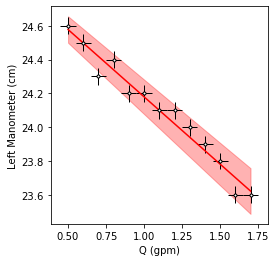

In [15]:
ax, cal1L_fit, cal1L_err = calibration_plot(x, y1, dx, dy1, plot=True)
plt.xlabel('Q (gpm)')
plt.ylabel('Left Manometer (cm)')
ax.set_aspect(1.0/ax.get_data_ratio());
# plt.savefig('Figures\Cal1 Left.png', dpi=300);

In [16]:
cal1L_fit = [ufloat(fit, err) for fit, err in zip(cal1L_fit, cal1L_err)]

Plotting cal. curve for right manometer

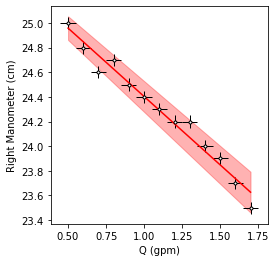

In [17]:
ax, cal1R_fit, cal1R_err = calibration_plot(x, y2, dx, dy2, plot=True)
plt.xlabel('Q (gpm)')
plt.ylabel('Right Manometer (cm)')
ax.set_aspect(1.0/ax.get_data_ratio());
# plt.savefig('Figures\Cal1 Right.png', dpi=300);

In [18]:
cal1R_fit = [ufloat(fit, err) for fit, err in zip(cal1R_fit, cal1R_err)]

### Use cal. curve to adjust Bed 1 measurements
*Note that $h_l$ = Left - Right*

In [19]:
df_dat1['Left (cm)'] = df_dat1['Left (cm)'] - linfit(df_dat1['Q (gpm)'], *cal1L_fit)
df_dat1['Right (cm)'] = df_dat1['Right (cm)'] - linfit(df_dat1['Q (gpm)'], *cal1R_fit)

### Obtain and plot $\text{Re}_d$ and $f_v$

In [20]:
df_dat1.head()

,Q (gpm),Left (cm),Right (cm),Packing
0,0.90+/-0.05,4.34+/-0.09,-4.51+/-0.11,Cu(m)
1,1.30+/-0.05,8.76+/-0.10,-8.97+/-0.13,Cu(m)
2,0.60+/-0.05,2.20+/-0.09,-2.25+/-0.11,Cu(m)
3,1.60+/-0.05,12.30+/-0.11,-12.54+/-0.14,Cu(m)
4,1.00+/-0.05,5.52+/-0.10,-5.40+/-0.12,Cu(m)


Need $h_l$ and $u$ and to convert all units appropriately:
* Q = m^3/s
* h_l = meters
* u = m/s

In [21]:
df_dat1['h_l'] = 1e-2*(df_dat1['Left (cm)'] - df_dat1['Right (cm)'])
df_dat1['Q (m^3/s)'] = df_dat1['Q (gpm)']/15850.32314
df_dat1['u'] = df_dat1['Q (m^3/s)']/(np.pi/4*B_D**2)
df_dat1['Re'] = water_rho*CuM_D*df_dat1['u']/water_mu
df_dat1['f_p'] = df_dat1['h_l']*CuM_D*9.81/(B1_h*df_dat1['u']**2)
df_dat1['f_v'] = df_dat1['f_p']*B1_phi**3*df_dat1['Re']/(1-B1_phi)**2

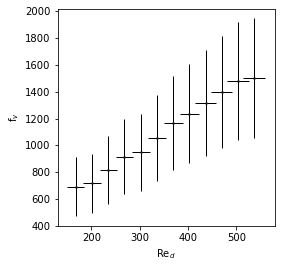

In [22]:
x = unp.nominal_values(df_dat1['Re'])
y = unp.nominal_values(df_dat1['f_v'])
dx = unp.std_devs(df_dat1['Re'])
dy = unp.std_devs(df_dat1['f_v'])

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
plt.errorbar(x, y, dy, dx, 'k.',
             markersize=3, markerfacecolor='w', label='Data',
             elinewidth=1
            )
plt.xlabel('Re$_d$')
plt.ylabel('f$_v$')
ax1.set_aspect(1.0/ax1.get_data_ratio());

### Plot Ergun, KTA, and best fit

In [23]:
def KTA(Re, phi):
    return 160 + 3*(Re/(1-phi))**0.9
def Erg(Re, phi):
    return 150 + 1.75*Re/(1-phi)
def PDfit1(Re, a, b): # Cu(m)
    return 160 + a*(Re/(1-B1_phi.nominal_value))**b
def PDfit2(Re, a, b): # Cu(s)
    return 160 + a*(Re/(1-B2_phi.nominal_value))**b
def PDfit3(Re, a, b): # Cu(L)
    return 160 + a*(Re/(1-B3_phi.nominal_value))**b

In [24]:
def add_PDfit(fitfun, x, y, dx, dy, plot=False, ax=None):
        
    mean_dx = np.mean(dx)
    mean_dy = np.mean(dy)
    
    weights = 1/(dx/mean_dx+dy/mean_dy)
    
    fit, cov = curve_fit(fitfun, x, y, sigma=weights, p0=[3, 0.9])
    err = np.sqrt(np.diagonal(cov))
    
    xdata = np.linspace(min(x), max(x))
    ydata = fitfun(xdata, *fit)
    errp = fitfun(xdata, *(fit+err))
    errn = fitfun(xdata, *(fit-err))
    
    if plot:
        assert ax
        ax.plot(xdata, ydata, 'k-', label='Best Fit')
        ax.fill_between(xdata, errp, errn, color='k', alpha=0.1)
        return fit, err
    
    return fit, err

In [25]:
x_ufloat = df_dat1['Re'].sort_values()
x = unp.nominal_values(x_ufloat)

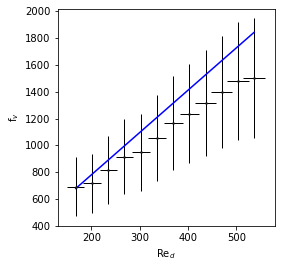

In [26]:
erg1 = Erg(x_ufloat, B1_phi)
y = unp.nominal_values(erg1)
dy = unp.std_devs(erg1)
ax1.plot(x, y, 'b', label='Ergun')
ax1.set_aspect(1.0/ax1.get_data_ratio());
fig1

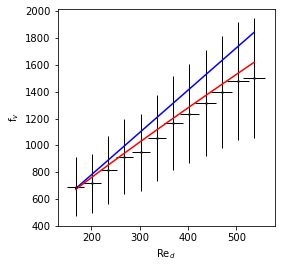

In [27]:
kta1 = KTA(x_ufloat, B1_phi)
y = unp.nominal_values(kta1)
dy = unp.std_devs(kta1)
ax1.plot(x, y, 'r', label='KTA')
ax1.set_aspect(1.0/ax1.get_data_ratio());
fig1

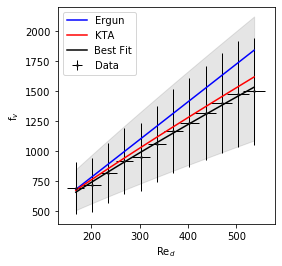

In [28]:
x = unp.nominal_values(df_dat1['Re'])
y = unp.nominal_values(df_dat1['f_v'])
dx = unp.std_devs(df_dat1['Re'])
dy = unp.std_devs(df_dat1['f_v'])
B1_fit, B1_err = add_PDfit(PDfit1, x, y, dx, dy, plot=True, ax=ax1)
ax1.set_aspect(1.0/ax1.get_data_ratio())
ax1.legend(loc='upper left')
fig1.savefig('Figures/Bed 1 Cu(m).png', dpi=300);
fig1

In [29]:
print('Coefficients of Bed 1 (Cu(m)) best fit line:')
for i, valerr in enumerate(zip(B1_fit, B1_err)):
    val, err = valerr
    print(f'Coefficient {i}: {val} +/- {err}')

Coefficients of Bed 1 (Cu(m)) best fit line:
Coefficient 0: 3.3354805600427984 +/- 0.6113467242142422
Coefficient 1: 0.8758010488006743 +/- 0.027555093182653274


# Repeat for Beds 2 & 3 (Cu(s) & Cu(L))

### Calibration curve

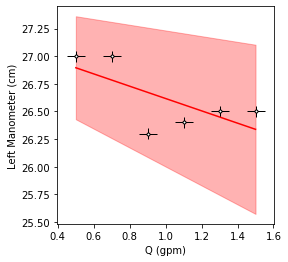

In [30]:
x = unp.nominal_values(df_cal2['Q (gpm)'])
y1 = unp.nominal_values(df_cal2['Left (cm)'])
y2 = unp.nominal_values(df_cal2['Right (cm)'])
dx = unp.std_devs(df_cal2['Q (gpm)'])
dy1 = unp.std_devs(df_cal2['Left (cm)'])
dy2 = unp.std_devs(df_cal2['Right (cm)'])
ax, cal2L_fit, cal2L_err = calibration_plot(x, y1, dx, dy1, plot=True)
plt.xlabel('Q (gpm)')
plt.ylabel('Left Manometer (cm)')
ax.set_aspect(1.0/ax.get_data_ratio())
# plt.savefig('Figures\cal2 Left.png', dpi=300)
cal2L_fit = [ufloat(fit, err) for fit, err in zip(cal2L_fit, cal2L_err)];

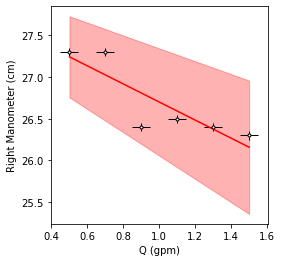

In [31]:
ax, cal2R_fit, cal2R_err = calibration_plot(x, y2, dx, dy2, plot=True)
plt.xlabel('Q (gpm)')
plt.ylabel('Right Manometer (cm)')
ax.set_aspect(1.0/ax.get_data_ratio())
# plt.savefig('Figures\cal2 Right.png', dpi=300)
cal2R_fit = [ufloat(fit, err) for fit, err in zip(cal2R_fit, cal2R_err)];

In [32]:
df_dat2['Left (cm)'] = df_dat2['Left (cm)'] - linfit(df_dat2['Q (gpm)'], *cal2L_fit)
df_dat2['Right (cm)'] = df_dat2['Right (cm)'] - linfit(df_dat2['Q (gpm)'], *cal2R_fit)

### Get non-packing specific parameters

In [33]:
df_dat2['h_l'] = 1e-2*(df_dat2['Left (cm)'] - df_dat2['Right (cm)'])
df_dat2['Q (m^3/s)'] = df_dat2['Q (gpm)']/15850.32314
df_dat2['u'] = df_dat2['Q (m^3/s)']/(np.pi/4*B_D**2)

### Split day 2 trials into beds 2 & 3

In [34]:
df_dat3 = df_dat2[df_dat2['Packing'] == 'Cu(L)']
df_dat2 = df_dat2[df_dat2['Packing'] == 'Cu(s)']

## Analyzing Bed 2: Cu(S)
### Obtain and plot $\text{Re}_d$ and $f_v$

In [35]:
df_dat2['Re'] = water_rho*CuS_D*df_dat2['u']/water_mu
df_dat2['f_p'] = df_dat2['h_l']*CuS_D*9.81/(B2_h*df_dat2['u']**2)
df_dat2['f_v'] = df_dat2['f_p']*B2_phi**3*df_dat2['Re']/(1-B2_phi)**2

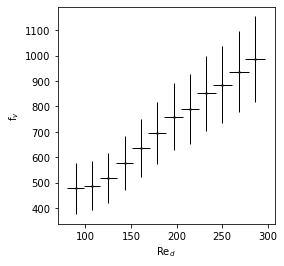

In [36]:
x = unp.nominal_values(df_dat2['Re'])
y = unp.nominal_values(df_dat2['f_v'])
dx = unp.std_devs(df_dat2['Re'])
dy = unp.std_devs(df_dat2['f_v'])
plt.errorbar(x, y, dy, dx, 'k.',
             markersize=3, markerfacecolor='w', label='Data',
             elinewidth=1
            )
plt.xlabel('Re$_d$')
plt.ylabel('f$_v$')
fig = plt.gcf()
ax = plt.gca()
ax.set_aspect(1.0/ax.get_data_ratio());

In [37]:
x_ufloat = df_dat2['Re'].sort_values()
x = unp.nominal_values(x_ufloat)

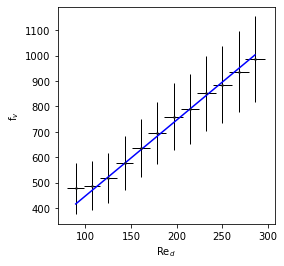

In [38]:
erg1 = Erg(x_ufloat, B2_phi)
y = unp.nominal_values(erg1)
dy = unp.std_devs(erg1)
ax.plot(x, y, 'b', label='Ergun')
ax.set_aspect(1.0/ax.get_data_ratio());
fig

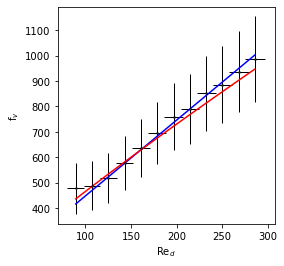

In [39]:
kta1 = KTA(x_ufloat, B2_phi)
y = unp.nominal_values(kta1)
dy = unp.std_devs(kta1)
ax.plot(x, y, 'r', label='KTA')
ax.set_aspect(1.0/ax.get_data_ratio());
fig

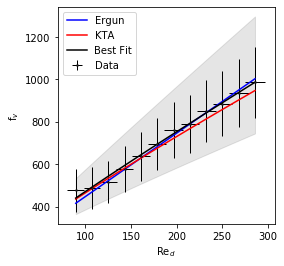

In [40]:
x = unp.nominal_values(df_dat2['Re'])
y = unp.nominal_values(df_dat2['f_v'])
dx = unp.std_devs(df_dat2['Re'])
dy = unp.std_devs(df_dat2['f_v'])
B2_fit, B2_err = add_PDfit(PDfit2, x, y, dx, dy, plot=True, ax=ax)
ax.set_aspect(1.0/ax.get_data_ratio())
ax.legend(loc='upper left');
fig.savefig('Figures/Bed 2 Cu(s).png', dpi=300);
fig

In [41]:
print('Coefficients of Bed 2 (Cu(s)) best fit line:')
for i, valerr in enumerate(zip(B2_fit, B2_err)):
    val, err = valerr
    print(f'Coefficient {i}: {val} +/- {err}')

Coefficients of Bed 2 (Cu(s)) best fit line:
Coefficient 0: 2.6637316084712026 +/- 0.43176829768899994
Coefficient 1: 0.9270177091070191 +/- 0.027192028629950363


## Analyzing Bed 3: Cu(L)

In [42]:
df_dat3['Re'] = water_rho*CuL_D*df_dat3['u']/water_mu
df_dat3['f_p'] = df_dat3['h_l']*CuL_D*9.81/(B3_h*df_dat3['u']**2)
df_dat3['f_v'] = df_dat3['f_p']*B3_phi**3*df_dat3['Re']/(1-B3_phi)**2

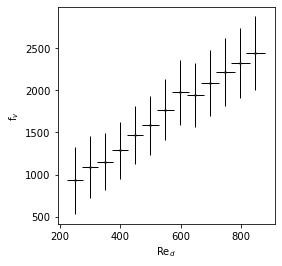

In [43]:
x = unp.nominal_values(df_dat3['Re'])
y = unp.nominal_values(df_dat3['f_v'])
dx = unp.std_devs(df_dat3['Re'])
dy = unp.std_devs(df_dat3['f_v'])
plt.errorbar(x, y, dy, dx, 'k.',
             markersize=3, markerfacecolor='w', label='Data',
             elinewidth=1
            )
plt.xlabel('Re$_d$')
plt.ylabel('f$_v$')
fig = plt.gcf()
ax = plt.gca()
ax.set_aspect(1.0/ax.get_data_ratio());

In [44]:
x_ufloat = df_dat3['Re'].sort_values()
x = unp.nominal_values(x_ufloat)

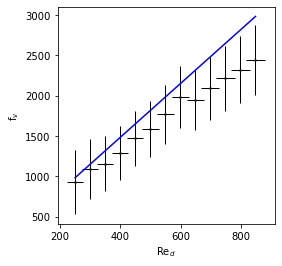

In [45]:
erg1 = Erg(x_ufloat, B3_phi)
y = unp.nominal_values(erg1)
dy = unp.std_devs(erg1)
ax.plot(x, y, 'b', label='Ergun')
ax.set_aspect(1.0/ax.get_data_ratio());
fig

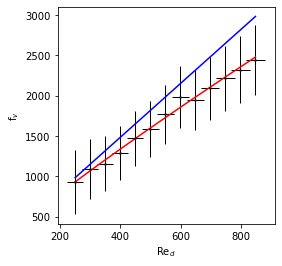

In [46]:
kta1 = KTA(x_ufloat, B3_phi)
y = unp.nominal_values(kta1)
dy = unp.std_devs(kta1)
ax.plot(x, y, 'r', label='KTA')
ax.set_aspect(1.0/ax.get_data_ratio());
fig

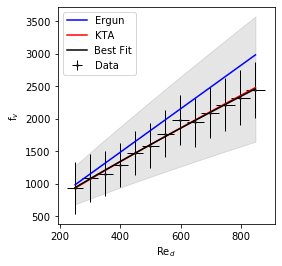

In [47]:
x = unp.nominal_values(df_dat3['Re'])
y = unp.nominal_values(df_dat3['f_v'])
dx = unp.std_devs(df_dat3['Re'])
dy = unp.std_devs(df_dat3['f_v'])
B3_fit, B3_err = add_PDfit(PDfit3, x, y, dx, dy, plot=True, ax=ax)
ax.set_aspect(1.0/ax.get_data_ratio())
ax.legend(loc='upper left');
fig.savefig('Figures/Bed 3 Cu(L).png', dpi=300);
fig

In [48]:
print('Coefficients of Bed 3 (Cu(L)) best fit line:')
for i, valerr in enumerate(zip(B1_fit, B1_err)):
    val, err = valerr
    print(f'Coefficient {i}: {val} +/- {err}')

Coefficients of Bed 3 (Cu(L)) best fit line:
Coefficient 0: 3.3354805600427984 +/- 0.6113467242142422
Coefficient 1: 0.8758010488006743 +/- 0.027555093182653274
